# SCC0633/SCC5908 - Processamento de Linguagem Natural
> **Docente:** Thiago Alexandre Salgueiro Pardo \\
> **Estagiário PAE:** Germano Antonio Zani Jorge


# Integrantes do Grupo: GPTrouxas
> André Guarnier De Mitri - 11395579 \\
> Daniel Carvalho - 10685702 \\
> Fernando - 11795342 \\
> Lucas Henrique Sant'Anna - 10748521 \\
> Magaly L Fujimoto - 4890582 \\


# Abordagem SIMBÓLICA
A arquitetura da solução simbólica envolve duas etapas principais: a primeira será uma abordagem simbólica, na qual serão utilizadas as frequências de palavras advindas de uma word cloud e a segunda etapa é usar uma ferramenta léxica chamada SentiWordNet.


Nesta primeira etapa será realizado um pré-processamento para depois ser gerada uma word cloud para cada classe de sentimento, positiva ou negativa. As palavras mais frequentes irão compor um conjunto de palavras que serão utilizados para aplicar a regra para avaliação da nova frase.


Na segunda etapa também será realizado um pré-processamento semelhante a etapa anterior, como a remoção das stopwords, apenas diferenciando que não será realizado a stemização (stemming). Os tokens serão obtidos e identificados com as tags para serem consultados no dicionário SentiWordNet. Utilizaremos o SentiWordNet como um vocabulário de palavras com sentimentos associados para comparação da abordagem anterior.

![alt text](../imagens/Simbolico_WordCloud_Wordnet.png)


## Pré Processamento
1. Transformar todos os textos em lowercase \\
2. Remoção das tags HTML \\
3. Remoção das urls \\
4. Remoção dos sinais de pontuação \\
5. Remoção de emojis \\
6. Remoção de stop words \\
7. Stemização (Stemming) para a primeira etapa, geração do word cloud \\

# Importação de Bibliotecas

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os
from bs4 import BeautifulSoup


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Baixando e Carregando os dados

In [2]:
import pandas as pd
# !wget -O imdb.csv "https://drive.google.com/uc?export=download&id=16HJTOZE7MluSPwRRluY9s2X4akGnZFAp"


In [3]:
df = pd.read_csv('../data/imdb_reviews.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.columns

Index(['review', 'sentiment'], dtype='object')

# Abordagem Simbólica 1: WordNet
Para implementar a análise de sentimentos usando WordNet, seguimos os passos abaixo:

1. **Tokenização e Anotação**:
   - Dividimos o texto em sentenças usando `nltk.sent_tokenize`.
   - Em seguida, dividimos cada sentença em palavras usando `nltk.word_tokenize`.
   - Anotamos cada palavra com sua tag de POS (part-of-speech) usando `nltk.pos_tag_sents`.

2. **Filtragem de Stopwords**:
   - Removemos stopwords do conjunto de palavras tokenizadas para focar apenas nas palavras significativas.

3. **Mapeamento de POS Tags**:
   - Convertendo as tags de POS para os formatos reconhecidos pelo SentiWordNet, utilizando um dicionário de mapeamento (`tagsswn`).

4. **Aplicação do SentiWordNet**:
   - Para cada palavra, aplicamos o SentiWordNet para obter os scores de sentimentos positivos e negativos.
   - Utilizamos a função `senti_synsets` do SentiWordNet para buscar os conjuntos de sinônimos que correspondem à palavra e à sua tag de POS.

5. **Cálculo dos Scores de Sentimentos**:
   - Para cada palavra, somamos os scores positivos e negativos dos conjuntos de sinônimos encontrados.
   - Calculamos a soma total dos scores positivos e negativos para o texto inteiro.

6. **Classificação de Sentimentos**:
   - Comparamos os scores positivos e negativos calculados.
   - Se o score positivo total for maior que o score negativo, classificamos o texto como "positivo".
   - Caso contrário, classificamos o texto como "negativo".



In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def lowercase_text(text):
    return text.lower()

def remove_html(text):
    return re.sub(r'<[^<]+?>', '', text)

def remove_url(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

def remove_punctuations(text):
    tokens_list = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for char in text:
        if char in tokens_list:
            text = text.replace(char, ' ')

    return text

def remove_emojis(text):
    emojis = re.compile("["
                        u"\U0001F600-\U0001F64F"
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\U00002500-\U00002BEF"
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"
                        u"\u3030"
                        "]+", re.UNICODE)

    text = re.sub(emojis, '', text)
    return text

def remove_stop_words(text):
    #nltk.download('stopwords')
    stop_words = stopwords.words('english')
    new_text = ''
    for word in text.split():
        if word not in stop_words:
            new_text += ''.join(f'{word} ')

    return new_text.strip()

def stem_words(text):
    stemmer = PorterStemmer()
    new_text = ''
    for word in text.split():
        new_text += ''.join(f'{stemmer.stem(word)} ')

    return new_text

def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_punctuations(text)
    text = remove_emojis(text)
    text = remove_stop_words(text)
    text = stem_words(text)

    return text



In [6]:
df['preprocessed_review'] = df['review'].copy()
df['preprocessed_review'] = df['preprocessed_review'].apply(preprocess_text)
cols = ['review','preprocessed_review','sentiment']


In [7]:
df['preprocessed_review'] = df['preprocessed_review'].astype(str)

In [8]:

def get_sentiment(aval):
    """
    Calcula o score de sentimento de um texto usando SentiWordNet.

    Entrada:
        aval (str): Texto a ser analisado.

    Saída:
        tuple: Score positivo e negativo do texto.
    """
    pos_scores = []
    neg_scores = []
    #aval = df['preprocessed_review'].copy()
    sentences = nltk.sent_tokenize(aval)
    sentence_words = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentence_words = flatten(nltk.pos_tag_sents(sentence_words))

    tagged_sentence_words = [word for word in tagged_sentence_words if word[0].lower() not in stpwrds]

    for word, pos in tagged_sentence_words:

        swn_pos = tagsswn.get(pos[:2], None)
        if not swn_pos:
            continue

        synsets = list(swn.senti_synsets(word.lower(), swn_pos))

        if not synsets:
            continue

        synset = synsets[0]
        pos_scores.append(synset.pos_score())
        neg_scores.append(synset.neg_score())

    sump = np.sum(pos_scores) if pos_scores else 0
    sumn = np.sum(neg_scores) if neg_scores else 0

    return sump, sumn

def classify_sentiment(aval):
    """
    Classifica um texto como positivo ou negativo com base no score de sentimento.

    Entrada:
        aval (str): Texto a ser classificado.

    Saída:
        str: "positive" se o score positivo for maior, "negative" caso contrário.
    """
    pos_score, neg_score = get_sentiment(aval)
    return "positive" if pos_score > neg_score else "negative"

# Converte em uma matriz unidimensional
flatten = lambda l: [item for sublist in l for item in sublist]

## Resultado da Classificação

In [9]:
# Stopwords
stpwrds = set(stopwords.words("english"))

# SentiWordNet POS tags
tagsswn = {
    "NN": "n",
    "VB": "v",
    "JJ": "a",
    "RB": "r",
}

# Classificar cada review no DataFrame usando SentiWordNet
df['WordNet_classification'] = df['preprocessed_review'].apply(classify_sentiment)

# Criar wordclouds para as reviews classificadas como positivas e negativas
positive_reviews = ' '.join(df[df['WordNet_classification'] == 'positive']['review'])
negative_reviews = ' '.join(df[df['WordNet_classification'] == 'negative']['review'])

df.head()

# Abordagem Simbólica 2: WordCloud

A segunda abordagem para análise de sentimentos envolve o uso de WordClouds para identificar as palavras mais frequentes em textos classificados como positivos e negativos. Aqui está o processo resumido:

1. **Geração de WordClouds**:
   - Utilizamos as reviews classificadas como "positivas" e "negativas" para criar duas WordClouds separadas, uma para cada categoria.
   - Uma WordCloud é uma representação visual das palavras mais frequentes em um texto, onde o tamanho das palavras é proporcional à sua frequência.

2. **Criação de Dicionários de Palavras**:
   - A partir das WordClouds geradas, extraímos as palavras mais frequentes.
   - Estas palavras formam os dicionários de palavras positivas e negativas, representando os termos que estão associados a sentimentos positivos e negativos, respectivamente.

3. **Classificação Baseada nos Dicionários com Regras Adicionais**:
   - Para classificar novos textos, contamos a ocorrência das palavras nos dicionários de palavras positivas e negativas.
   - Além disso, aplicamos regras adicionais para capturar nuances mais sutis na linguagem:
     - **"not" seguido de uma palavra positiva:** Se a palavra "not" for seguida de uma palavra positiva, isso indica um contexto negativo.
     - **"too" seguido de uma palavra negativa:** Se a palavra "too" for seguida de uma palavra negativa, isso reforça o sentimento negativo.
     - **"very" seguido de uma palavra positiva:** Se a palavra "very" for seguida de uma palavra positiva, isso reforça o sentimento positivo.
     - **"but" entre palavras positivas e negativas:** Se a palavra "but" aparecer entre uma palavra positiva e uma palavra negativa, a palavra após "but" geralmente tem mais peso no sentimento do texto.
   - Se um texto contém mais palavras do dicionário positivo do que do negativo, classificamos o texto como "positivo", e vice-versa.

Essa abordagem é baseada na suposição de que certas palavras são mais associadas a sentimentos positivos ou negativos, e a frequência dessas palavras nos textos, combinada com regras adicionais de contexto, pode ser usada para determinar o sentimento geral do texto.




In [ ]:
# Stopwords
stpwrds = set(stopwords.words("english"))
additional_stopwords = {"br br", "movie", "film", "one", "like"} # Essas palavras estão presentes em ambas wordclouds
stpwrds.update(additional_stopwords)


def wordcloud_draw(text, title, color='white'):
    """
    Gera e exibe uma wordcloud a partir de um texto.

    Entrada:
        text (str): Texto para gerar a wordcloud.
        title (str): Título da wordcloud.
        color (str): Cor de fundo da wordcloud.

    Saída:
        WordCloud: Objeto WordCloud gerado.
    """
    wordcloud = WordCloud(stopwords=stpwrds, background_color=color, width=2500, height=2500).generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontsize=20, pad=20)
    plt.show()
    return wordcloud

def create_dictionary_from_wordcloud(text, num_words=15):
    """
    Cria um dicionário das palavras mais frequentes de uma wordcloud.

    Entrada:
        text (str): Texto para gerar a wordcloud.
        num_words (int): Número de palavras mais frequentes para incluir no dicionário.

    Saída:
        list: Lista das palavras mais frequentes.
    """
    wordcloud = WordCloud(stopwords=stpwrds, background_color='white').generate(text)
    freq_words = wordcloud.words_
    return list(freq_words.keys())[:num_words]

def classify_with_dictionary(text, pos_words, neg_words):
    """
    Classifica um texto como positivo ou negativo com base na frequência das palavras em dicionários predefinidos.

    Entrada:
        text (str): Texto a ser classificado.
        pos_words (list): Lista de palavras positivas.
        neg_words (list): Lista de palavras negativas.

    Saída:
        str: "positive" se a contagem de palavras positivas for maior, "negative" caso contrário.
    """
    words = word_tokenize(text.lower())

    pos_count = sum(1 for word in words if word in pos_words)
    neg_count = sum(1 for word in words if word in neg_words)

    # Regras adicionais para combinações específicas
    for i, word in enumerate(words):

        negate = ["not", "arent", "cannot", "cant", "couldnt", "didnt", "doesnt", "aren't", "can't", "couldn't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "wasnt", "werent", "wasn't", "weren't", "wont", "won't"]

        # REGRAS 1: Se "NOT" seguido de algo positivo, indica algo ruim. Se "NOT" seguido de algo negativo, indica positivo
        for n in negate:
          if word == n and i + 1 < len(words):
            next_word = words[i + 1]
            if next_word in pos_words:
                neg_count += 1
                pos_count -= 1
            if next_word in neg_words:
                pos_count += 1
                neg_count -= 1
        # REGRAS 2: Se a palavra "too" for seguida de uma palavra negativa, o texto tende a ter um sentido negativo.
        if word == 'too' and i + 1 < len(words):
            next_word = words[i + 1]
            if next_word in neg_words:
                neg_count += 1
        # REGRAS 3: Se a palavra "very" for seguida de uma palavra positiva, o texto tende a ter um sentido positivo.
        if word == 'very' and i + 1 < len(words):
            next_word = words[i + 1]
            if next_word in pos_words:
                pos_count += 1
        # REGRA 4: Se a palavra "but" aparecer entre uma palavra positiva e uma palavra negativa, a palavra após "but" geralmente tem mais peso.
        if word == 'but' and i + 1 < len(words) and i - 1 >= 0:
            prev_word = words[i - 1]
            next_word = words[i + 1]
            if prev_word in pos_words and next_word in neg_words:
                neg_count += 1
                pos_count -= 1
            elif prev_word in neg_words and next_word in pos_words:
                pos_count += 1
                neg_count -= 1

    return "positive" if pos_count > neg_count else "negative"

## WordCloud dos sentimentos POSITIVOS

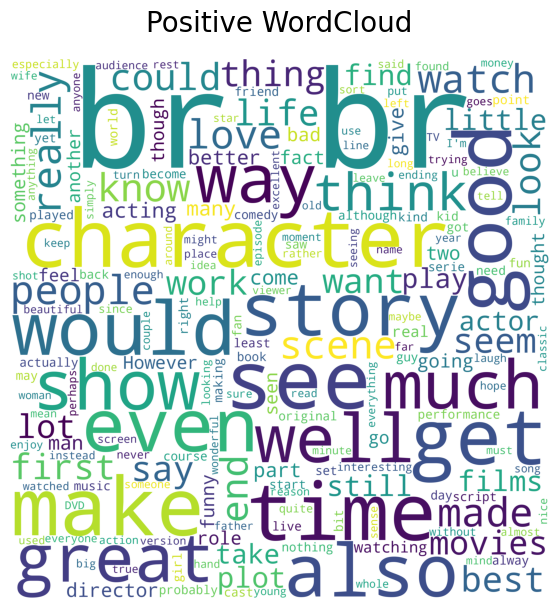

In [ ]:
wordcloud_draw(positive_reviews, "Positive WordCloud")
positive_words = create_dictionary_from_wordcloud(positive_reviews, num_words=15)

In [ ]:
print('Principais palavras POSITIVAS:', positive_words)

Principais palavras POSITIVAS: ['br br', 'see', 'make', 'character', 'time', 'good', 'get', 'would', 'story', 'even', 'also', 'show', 'way', 'great', 'much']


## WordCloud dos sentimentos NEGATIVOS

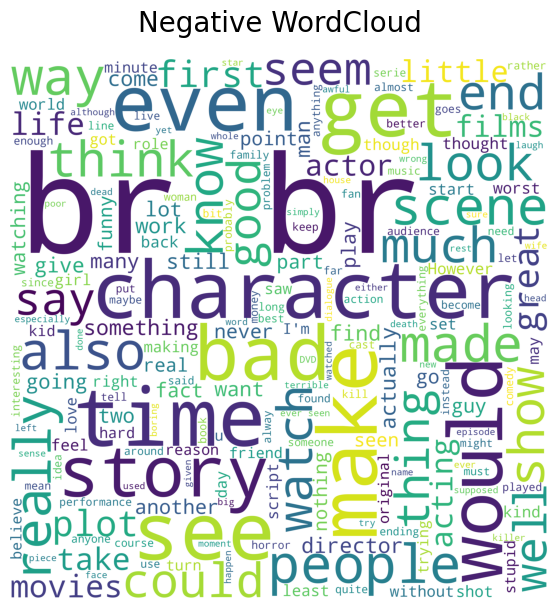

In [ ]:
wordcloud_draw(negative_reviews, "Negative WordCloud")
negative_words = create_dictionary_from_wordcloud(negative_reviews, num_words=15)

In [ ]:
print('Principais palavras NEGATIVAS:', negative_words)

Principais palavras NEGATIVAS: ['br br', 'make', 'time', 'see', 'character', 'get', 'even', 'bad', 'would', 'story', 'people', 'also', 'scene', 'way', 'really']


## Resultado da Classificação

In [ ]:
# Classificar cada review no DataFrame usando o dicionário de palavras
df['WordCloud_classification'] = df['preprocessed_review'].apply(lambda x: classify_with_dictionary(x, positive_words, negative_words))



# Avaliação das aboragens simbólicas

## Funcões para avaliação

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

# Função para calcular e imprimir as métricas de avaliação
def print_evaluation_metrics(y_true, y_pred, model_name):
    print(f"Classification Report {model_name}:")
    print(classification_report(y_true, y_pred))


## Avaliação WordNet

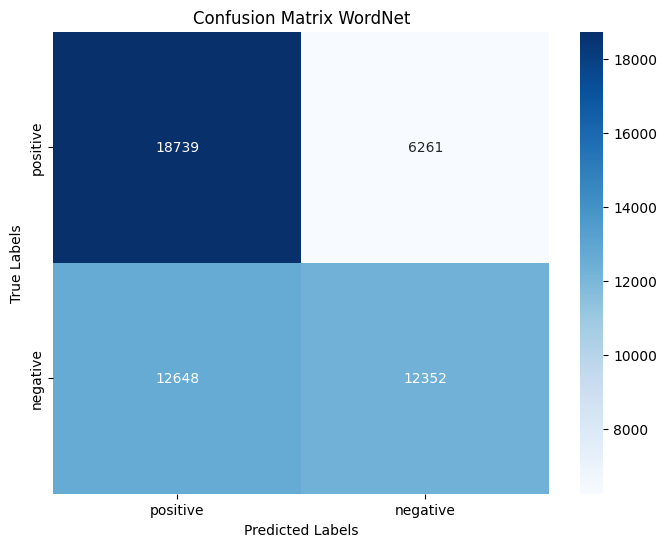

Classification Report WordNet:
              precision    recall  f1-score   support

    negative       0.66      0.49      0.57     25000
    positive       0.60      0.75      0.66     25000

    accuracy                           0.62     50000
   macro avg       0.63      0.62      0.62     50000
weighted avg       0.63      0.62      0.62     50000



In [ ]:
# Exemplo para WordNet Classification
model_name = 'WordNet'
y_true_wordnet = df['sentiment']
y_pred_wordnet = df['WordNet_classification']

# Plotar a matriz de confusão
plot_confusion_matrix(y_true_wordnet, y_pred_wordnet, ['positive', 'negative'], model_name)

# Imprimir as métricas de avaliação
print_evaluation_metrics(y_true_wordnet, y_pred_wordnet, model_name)

## Avaliação WordCloud

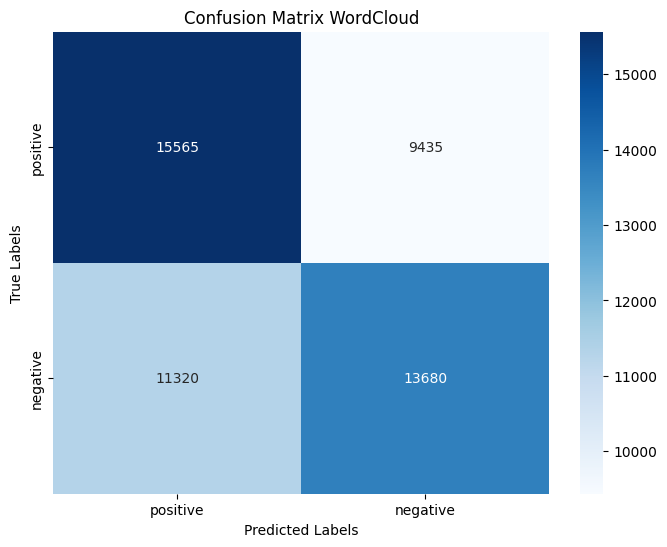

Classification Report WordCloud:
              precision    recall  f1-score   support

    negative       0.59      0.55      0.57     25000
    positive       0.58      0.62      0.60     25000

    accuracy                           0.58     50000
   macro avg       0.59      0.58      0.58     50000
weighted avg       0.59      0.58      0.58     50000



In [ ]:
# Exemplo para WordCloud Classification
y_true_wordcloud = df['sentiment']
y_pred_wordcloud = df['WordCloud_classification']
model_name= 'WordCloud'

# Plotar a matriz de confusão
plot_confusion_matrix(y_true_wordcloud, y_pred_wordcloud, ['positive', 'negative'], model_name)

# Imprimir as métricas de avaliação
print_evaluation_metrics(y_true_wordcloud, y_pred_wordcloud, model_name)

# Conclusão

Após analisar os relatórios de classificação para as duas abordagens de classificação de sentimentos (WordNet e WordCloud), podemos fazer as seguintes observações:

### WordNet Classification:

- A precisão para a classe positiva (0.60) é relativamente menor do que a precisão para a classe negativa (0.66), indicando que o modelo tende a classificar corretamente mais textos negativos do que positivos.
- O recall para a classe positiva (0.75) é maior do que o recall para a classe negativa (0.49), sugerindo que o modelo identifica com mais eficácia os textos positivos do que os negativos.
- O F1-score para ambas as classes é relativamente equilibrado, com uma pontuação mais alta para a classe positiva (0.66) em comparação com a classe negativa (0.57).
- A acurácia geral do modelo é de 0.62, o que significa que ele classifica corretamente cerca de 62% dos textos.

### WordCloud Classification:

- A precisão para ambas as classes (positiva e negativa) é mais equilibrada, com valores de 0.58 e 0.59, respectivamente.
- O recall para a classe negativa (0.55) é maior do que o recall para a classe positiva (0.62), indicando que o modelo identifica com mais eficácia os textos negativos do que os positivos.
- O F1-score para ambas as classes é mais equilibrado em comparação com o modelo WordNet, com pontuações de 0.57 para a classe negativa e 0.60 para a classe positiva.
- A acurácia geral do modelo é de 0.58, o que significa que ele classifica corretamente cerca de 58% dos textos.


**Conclusão**:
Ambas as abordagens têm suas vantagens e desvantagens. A abordagem usando WordNet tende a ser mais precisa na classificação de textos negativos, com um recall mais baixo para negativos em comparação com positivos, enquanto a abordagem usando WordCloud tem uma precisão mais equilibrada para ambas as classes. A acurácia geral do modelo WordNet é um pouco superior, indicando um desempenho ligeiramente melhor na classificação geral dos textos.
